In [13]:
import fasttext
import fasttext.util
import time
import torch
import random
import torch.nn as nn
from torch.nn import Linear, Sigmoid, ReLU, Dropout, Embedding, MSELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm1d, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ft = fasttext.load_model("cc.tr.100.bin")

In [4]:
#Given the input string and the fasttext object, returns the vectorized representations obtained
#from the embeddings of the fasttext model
#words: a list of strings that are the inputs to the model
#padding: the max number of words per input. if num_words is less than padding, fill with zero vectors
#in_vector: [batch_size, num_inp_words, (input_shape)] Tensor - reshape the vectors to 
#           (input_shape) matrices and stack them as channels
def get_input_vectors(words, padding, ft, input_shape):
    
    tokens = []
    batch_size = len(words)
    
    h, w = input_shape
    
    #loop over the batches to tokenize the inputs
    for i in range(batch_size):
        #Tokenize words using default fasttext tokenizer, which creates tokens 
        # by dividing splitting at word separating chars
        tokens.append(fasttext.tokenize(words[i]))

    #Create a matrix with batch_size batches, num token channels and 10x10 matrices to store the 100dim embeddings
    in_vector = np.zeros((batch_size, padding, h, w))
    
    
    #cycle over the tokens and get their vectors, reshape them to 10x10 and store in the corresponding 
    #channel in the return variable
    for j in range(len(tokens)):
        
        i = 0

        for token in tokens[j]:
            
            vector = torch.tensor(ft[token].astype(np.double))
            #print(vector.shape)
            vector = vector.reshape(h,w)
            #print(vector.shape)
#            print(vector.type())
            in_vector[j][i] = vector
            
         #   print(in_vector)
        
            i=i+1
            if(i == padding):
                break

    #create a tensor object to return
    in_vector = torch.tensor(in_vector)

    return in_vector

In [4]:
get_input_vectors(["merhaba benim adim alicanhas", "olmaz oyle is"], 4, ft, (25,4))

tensor([[[[-1.5190e-02,  4.3468e-02, -7.3120e-03, -8.8364e-02],
          [ 6.6431e-02, -2.6537e-03, -5.1465e-02, -1.5113e-01],
          [ 1.8008e-02, -1.1951e-01,  2.4819e-02,  1.2056e-01],
          [-4.0215e-02,  2.6504e-02,  1.3707e-02, -1.0654e-01],
          [ 6.6808e-04, -1.3248e-01,  6.3174e-03, -8.8804e-02],
          [ 1.8494e-02,  1.9514e-02, -1.1282e-01,  5.2123e-02],
          [ 6.5784e-02, -5.6832e-02,  5.1782e-02, -6.5021e-02],
          [-1.1455e-01,  5.9893e-02,  4.4935e-02, -1.2731e-01],
          [ 1.6933e-02,  8.6301e-02,  4.4566e-02,  4.2370e-02],
          [-1.3645e-02,  1.2660e-01, -5.3239e-02,  1.8602e-02],
          [-4.5847e-02, -6.3016e-03,  3.9904e-02,  2.9717e-02],
          [-4.7668e-02, -3.9630e-02,  1.2111e-02, -3.5818e-02],
          [ 6.5003e-02, -1.4607e-02,  7.3603e-03,  5.9358e-02],
          [-6.2426e-02,  3.8948e-02,  3.9458e-02,  4.5624e-03],
          [ 9.4100e-02,  6.0992e-02,  1.0559e-01, -1.7969e-02],
          [ 1.6857e-02,  9.4955e-03,  3.

In [59]:
class CNet(Module):
    def __init__(self):
        super(CNet, self).__init__()
        
        #self.embedding_layer = Embedding.from_pretrained(weights, freeze=True, padding_idx=0)
        
        self.cnn_layers = Sequential(
            #Convolutional Layer 1 [N, C, H, W]
            #in: [N, 8, 10, 10]
            #out: [N, 10, 9, 9]
            Conv2d(4, 10, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(10),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=1),
            
            #Convolutional Layer 2
            #in: [N, 10, 9, 9]
            #out: [N, 30, 5, 5]
            Conv2d(10, 30, kernel_size=5, stride=1),
            BatchNorm2d(30),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=1),
            
            #Convolutional Layer 3
            #in: [N, 30, 4, 4]
            #out: [N, 50, 3, 3]
            Conv2d(30, 50, kernel_size=1, stride=1),
            BatchNorm2d(50),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=1),
            
            #Convolutional Layer 4
            #in: [N, 50, 3, 3]
            #out: [N, 100, 1, 1]
            Conv2d(50, 100, kernel_size=3, stride=1),
            BatchNorm2d(100),
            ReLU(inplace=True),
        )
        
        #The linear fully connected layer at the end of the network that outputs a classification
        self.out_layers = Sequential(
            Linear(100, 256),
            ReLU(),
            Linear(256, 512),
            ReLU(),
            Linear(512, 512),
            ReLU(),
            Linear(512, 256),
            ReLU(),
            Linear(256, 64),
            ReLU(),
            Linear(64, 16),
            ReLU(),
            Linear(16, 16),
            ReLU(),
            Linear(16, 1),
            Sigmoid()
        )
        
    #Define the forward pass through the model 
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape((x.shape[0],x.shape[1]))
        #print("x shape:", x.shape)
        x = self.out_layers(x)
        return x
        

In [5]:
class LNet(Module):
    def __init__(self):
        super(LNet, self).__init__()
        self.drop_prob = 0.2
        self.drop = Dropout(self.drop_prob)
        
        #The linear fully connected layer at the end of the network that outputs a classification
        self.out_layers = Sequential(
            BatchNorm1d(100),    
            Linear(100, 256),
            BatchNorm1d(256),
            ReLU(),
            Linear(256, 512),
            BatchNorm1d(512),
            ReLU(),
            Linear(512, 1024),
            BatchNorm1d(1024),
            self.drop,
            ReLU(),
            Linear(1024, 1024),
            #BatchNorm1d(1024),
            ReLU(),
            Linear(1024, 1024),
            self.drop,
            BatchNorm1d(1024),
            ReLU(),
            Linear(1024, 512),
            BatchNorm1d(512),
            ReLU(),
            Linear(512, 256),
            ReLU(),
            Linear(256, 256),
            ReLU(),
            Linear(256, 256),
            BatchNorm1d(256),
            ReLU(),
            Linear(256, 256),
            BatchNorm1d(256),
            ReLU(),
            Linear(256, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 16),            
            BatchNorm1d(16),
            ReLU(),
            Linear(16, 1),
            Sigmoid()
        )
        
        
    #Define the forward pass through the model 
    def forward(self, x):
        x = torch.sum(x, 1)
        x = x.reshape((x.shape[0],x.shape[1]))
        x = self.out_layers(x)
        return x
        

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
def train(train_loader, model, loss, optimizer):

    model.train()
    
    last_loss = 0
    
    for i, data in enumerate(train_loader, 0):    

        inputs, labels = data

        optimizer.zero_grad()

        X_out = model(inputs.float())

        loss_tr = loss(X_out, labels)

        loss_tr.backward()

        optimizer.step()
        
        last_loss = loss_tr
    
    s = torch.sum(model.out_layers[7].weight.data)
    
    return last_loss, s

        


In [8]:
def test(model, val_loader, loss):
    
    model.eval()
    
    correct = 0
    total = 0
    test_loss = 0
    
    model = model.float()

    with torch.no_grad():
        for data in val_loader:
            
            sents, labels = data
            
            outputs = model(sents.float())
            
            test_loss = loss(outputs, labels)
            
            outputs = outputs>=0.5
            
            total += labels.size(0)
            correct += (outputs==labels).sum().item()
    
    accuracy = 100*correct/total

    #print("Accuracy on the validation set of ", total, " items is: ", (accuracy))
    
    return accuracy, test_loss
    

In [9]:
def read_file_to_str(file_path):
    
    file = open(file_path, 'r')
    
    data_x = []
    data_y = []
    
    n = 0
    newline = '\n'
    
    #Loop through the lines, and split at the comma for the inputs x and labels y
    for line in file:

        temp = line.split(",")
        
        temp[1] = temp[1].strip()
            
        if temp[0] == '':
            break

        data_y.append(float(temp[0]))
            
        if temp[1].endswith(newline):
            temp[1].replace(newline, '')
                   
        data_x.append(temp[1])
    
        n = n + 1

    file.close()
    
    return data_x, data_y, n
        

Epoch:  1  Train Loss: 0.249  Train Weights: 7.7  Test Loss: 0.249  Test Acc: 52.94
Epoch:  2  Train Loss: 0.242  Train Weights: 1.4  Test Loss: 0.249  Test Acc: 52.94
Epoch:  3  Train Loss: 0.189  Train Weights: -2.7  Test Loss: 0.249  Test Acc: 52.94
Epoch:  4  Train Loss: 0.172  Train Weights: -10.1  Test Loss: 0.249  Test Acc: 52.94
Epoch:  5  Train Loss: 0.153  Train Weights: -15.9  Test Loss: 0.245  Test Acc: 52.94
Epoch:  6  Train Loss: 0.137  Train Weights: -15.7  Test Loss: 0.227  Test Acc: 58.82
Epoch:  7  Train Loss: 0.120  Train Weights: -15.5  Test Loss: 0.181  Test Acc: 76.47
Epoch:  8  Train Loss: 0.102  Train Weights: -17.3  Test Loss: 0.143  Test Acc: 88.24
Epoch:  9  Train Loss: 0.133  Train Weights: -19.4  Test Loss: 0.145  Test Acc: 82.35
Epoch:  10  Train Loss: 0.126  Train Weights: -22.2  Test Loss: 0.226  Test Acc: 64.71
Epoch:  11  Train Loss: 0.070  Train Weights: -24.6  Test Loss: 0.118  Test Acc: 76.47
Epoch:  12  Train Loss: 0.070  Train Weights: -29.1  Test

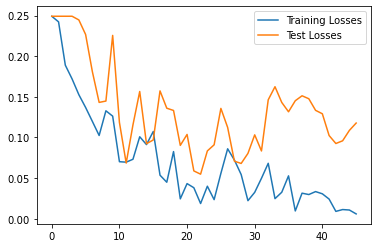

In [12]:

rand_seed = 40

torch.manual_seed(rand_seed)
np.random.seed(rand_seed)
random.seed(rand_seed)

verbose = False

X, Y, n = read_file_to_str("train.txt")


X = get_input_vectors(X, 4, ft, (100,1))
Y = torch.tensor(Y)
Y = Y.reshape(n, 1)


if verbose:
    print(Y.shape)
    print(X.shape)

data = TensorDataset(X, Y)

val_perc = 7/100
n_val = int(n*val_perc)
n_tr = n - n_val

data_val, data_tr = random_split(data, [n_val, n_tr])

train_loader = DataLoader(data_tr, batch_size=50, shuffle = True)
val_loader = DataLoader(data_val, batch_size=n_val, shuffle=True)

if verbose:
    print("Data_Val shape: ", n_val, "Data_tr: ", n_tr)

#define the model
model = LNet()

#optimizer
optimizer = Adam(model.parameters(), lr = 0.001)

#loss function
loss = nn.MSELoss()

if verbose:
    print(model)
    print("Total Parameters: ", count_parameters(model))

model = model.float()

train_losses = []
train_weights = []
test_accs = []
test_losses = []


epoch = 46

for e in range(epoch):
    
    train_loss, weight = train(train_loader, model, loss, optimizer)
    test_acc, test_loss = test(model, val_loader, loss)
    print("Epoch: ", e+1, " Train Loss: %.3f" %train_loss.item(), " Train Weights: %.1f" %weight.item(), 
          " Test Loss: %.3f" %test_loss, " Test Acc: %.2f" %test_acc,)
    train_losses.append(train_loss)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    train_weights.append(weight)

plt.plot(train_losses, label="Training Losses")
plt.plot(test_losses, label="Test Losses")
plt.legend()
plt.show()

In [ ]:

rand_seed = 40

torch.manual_seed(rand_seed)
np.random.seed(rand_seed)
random.seed(rand_seed)

verbose = False

X, Y, n = read_file_to_str("train.txt")
X_test, Y_test, n_test = read_file_to_str("test.txt")


X = get_input_vectors(X, 4, ft, (100,1))
Y = torch.tensor(Y)
Y = Y.reshape(n, 1)

X_test = get_input_vectors(X_test, 4, ft, (100,1))
Y_test = torch.tensor(Y_test)
Y_test = Y_test.reshape(n_test, 1)

if verbose:
    print(Y.shape)
    print(X.shape)

data = TensorDataset(X, Y)

testdata = TensorDataset(X_test, Y_test)

train_loader = DataLoader(data, batch_size=20, shuffle = True)
test_loader = DataLoader(testdata, batch_size=n_test, shuffle=False)

if verbose:
    print("Testdata shape: ", n_test, "Data: ", n)

#define the model
model = LNet()

#optimizer
optimizer = Adam(model.parameters(), lr = 0.001)

#loss function
loss = nn.MSELoss()

if verbose:
    print(model)
    print("Total Parameters: ", count_parameters(model))

model = model.float()

train_losses = []
train_weights = []
test_accs = []
test_losses = []


epoch = 46

for e in range(epoch):
    
    train_loss, weight = train(train_loader, model, loss, optimizer)
    test_acc, test_loss = test(model, test_loader, loss)
    print("Epoch: ", e+1, " Train Loss: %.3f" %train_loss.item(), " Train Weights: %.1f" %weight.item(), 
          " Test Loss: %.3f" %test_loss, " Test Acc: %.2f" %test_acc,)
    train_losses.append(train_loss)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    train_weights.append(weight)

plt.plot(train_losses, label="Training Losses")
plt.plot(test_losses, label="Test Losses")
plt.legend()
plt.show() 
plt.plot(test_accs, label="Test Accuracy")
plt.legend()
plt.show()

In [16]:
tst = get_input_vectors(["evora park bizi aşar"], 4, ft, (100,1))
model.eval()
model(tst.float()).item()

0.9163928627967834

In [17]:
model.eval()
torch.save(model.state_dict(), "./model_state.pth")

In [434]:
newModel = LNet()
newModel.load_state_dict(torch.load("./model_state.pth"))
newModel.eval()

LNet(
  (drop): Dropout(p=0.2, inplace=False)
  (out_layers): Sequential(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=100, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=1024, bias=True)
    (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=1024, bias=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): R

In [477]:
_, _, n = read_file_to_str("test.txt")
print('Num Train Examples: ', n)

Num Train Examples:  92


In [476]:
_, _, n = read_file_to_str("train.txt")
print('Num Train Examples: ', n)

Num Train Examples:  252
